<a href="https://colab.research.google.com/github/SairamKorimilla/MLProjects/blob/master/SampleProject/Parkinsons_UPDRS_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing libraries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Dataset

In [8]:
#clones the repo
!git clone https://github.com/SairamKorimilla/MLProjects.git
#enters the repo
%cd MLProjects
#reads the file
data = pd.read_csv("SampleProject/parkinsons_updrs.csv")
data.head()

Cloning into 'MLProjects'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 284.38 KiB | 1.27 MiB/s, done.
/content/MLProjects/MLProjects


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Data Analysis

   subject#  age  sex  test_time  motor_UPDRS  total_UPDRS  Jitter(%)  \
0         1   72    0     5.6431       28.199       34.398    0.00662   
1         1   72    0    12.6660       28.447       34.894    0.00300   
2         1   72    0    19.6810       28.695       35.389    0.00481   
3         1   72    0    25.6470       28.905       35.810    0.00528   
4         1   72    0    33.6420       29.187       36.375    0.00335   

   Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  ...  Shimmer(dB)  Shimmer:APQ3  \
0     0.000034     0.00401      0.00317  ...        0.230       0.01438   
1     0.000017     0.00132      0.00150  ...        0.179       0.00994   
2     0.000025     0.00205      0.00208  ...        0.181       0.00734   
3     0.000027     0.00191      0.00264  ...        0.327       0.01106   
4     0.000020     0.00093      0.00130  ...        0.176       0.00679   

   Shimmer:APQ5  Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE  \
0       0.01309        0.01662      

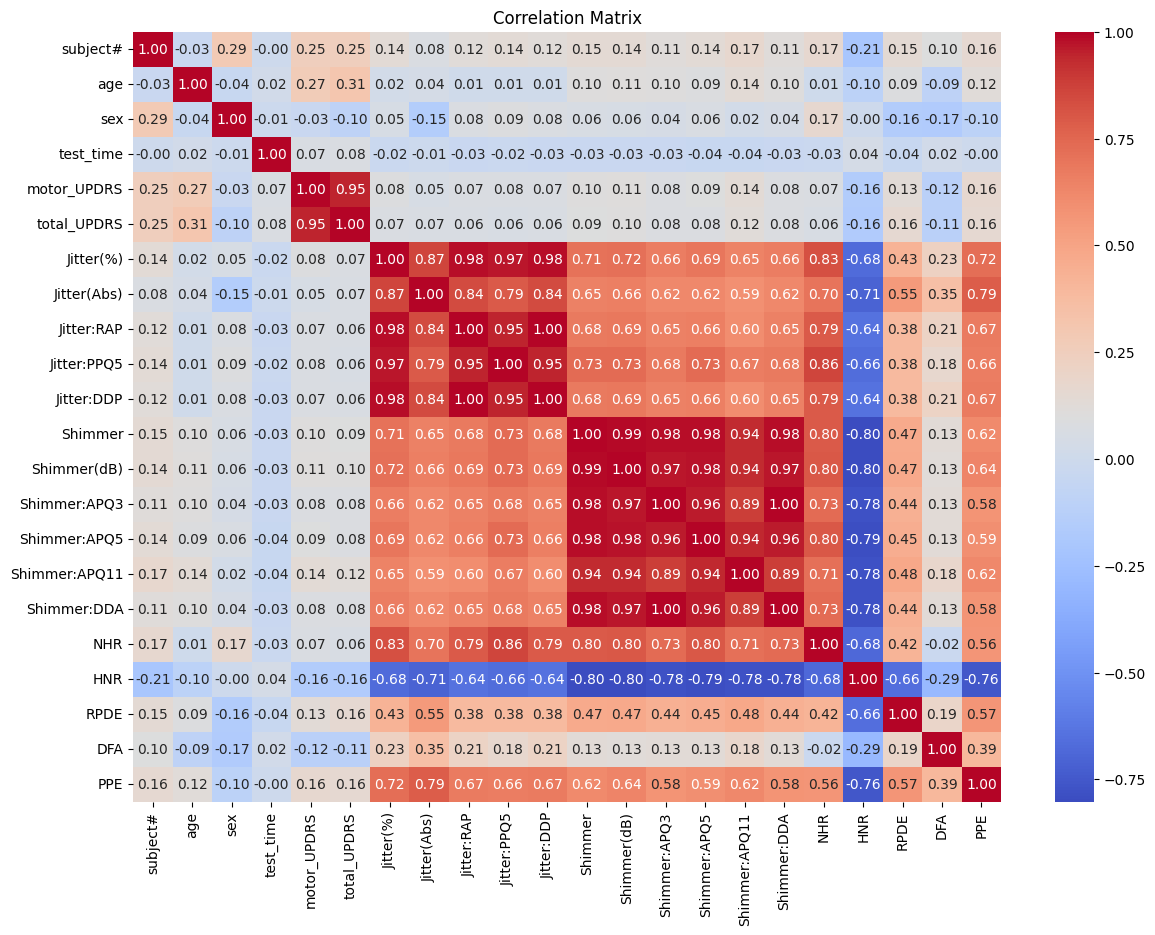

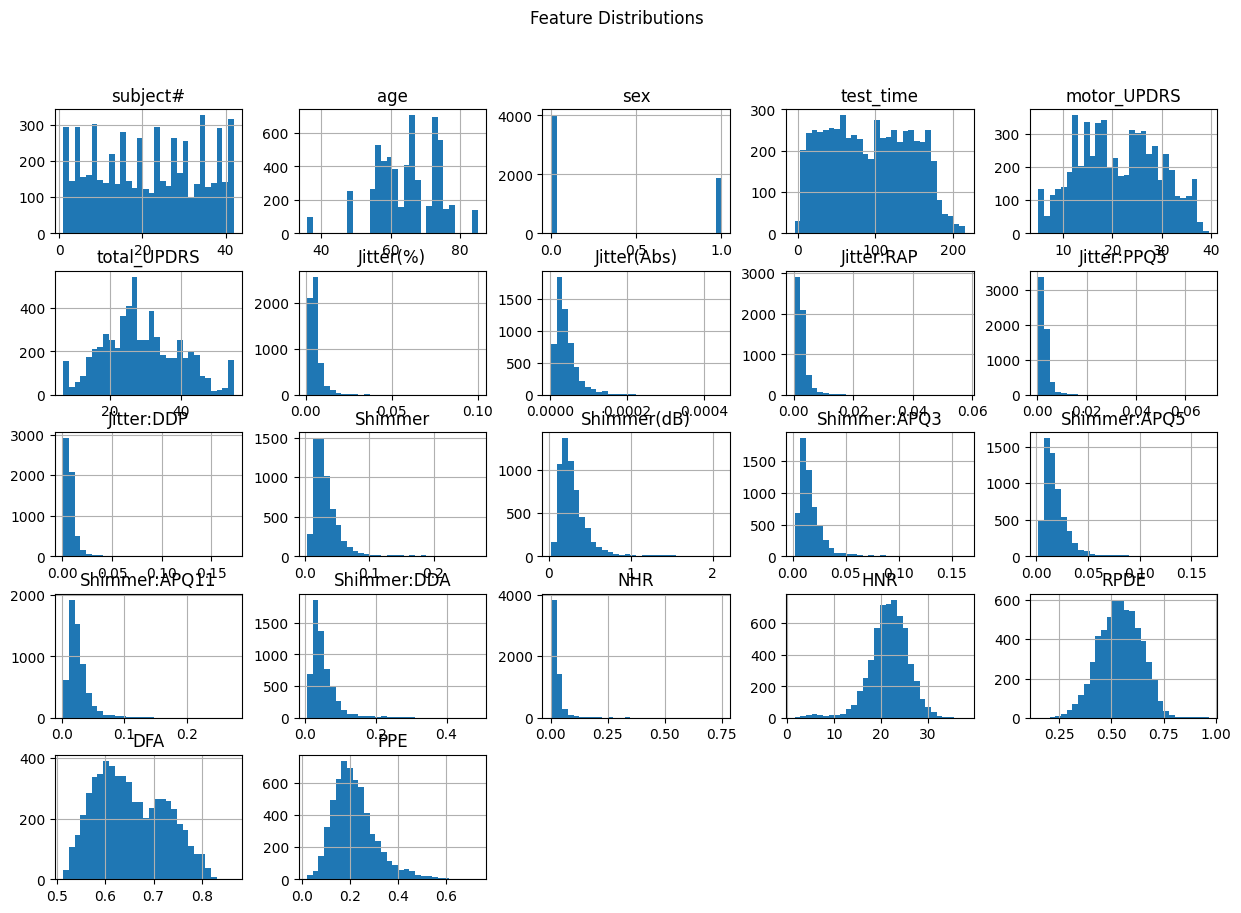

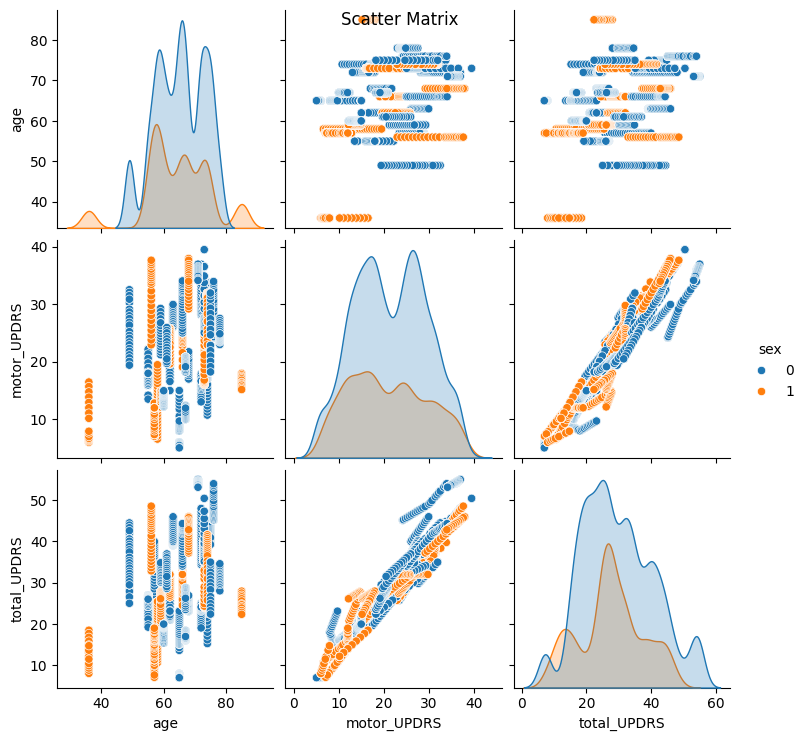

In [ ]:
# Check data structure and basic statistics
print(data.head())
print(data.info())
print(data.describe())

# Correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# Distributions of numeric features
data.hist(bins=30, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

# Scatter plots for age and target variables
sns.pairplot(data, vars=['age', 'motor_UPDRS', 'total_UPDRS'], hue='sex', diag_kind='kde')
plt.suptitle("Scatter Matrix")
plt.show()

Discover and Visualize Data

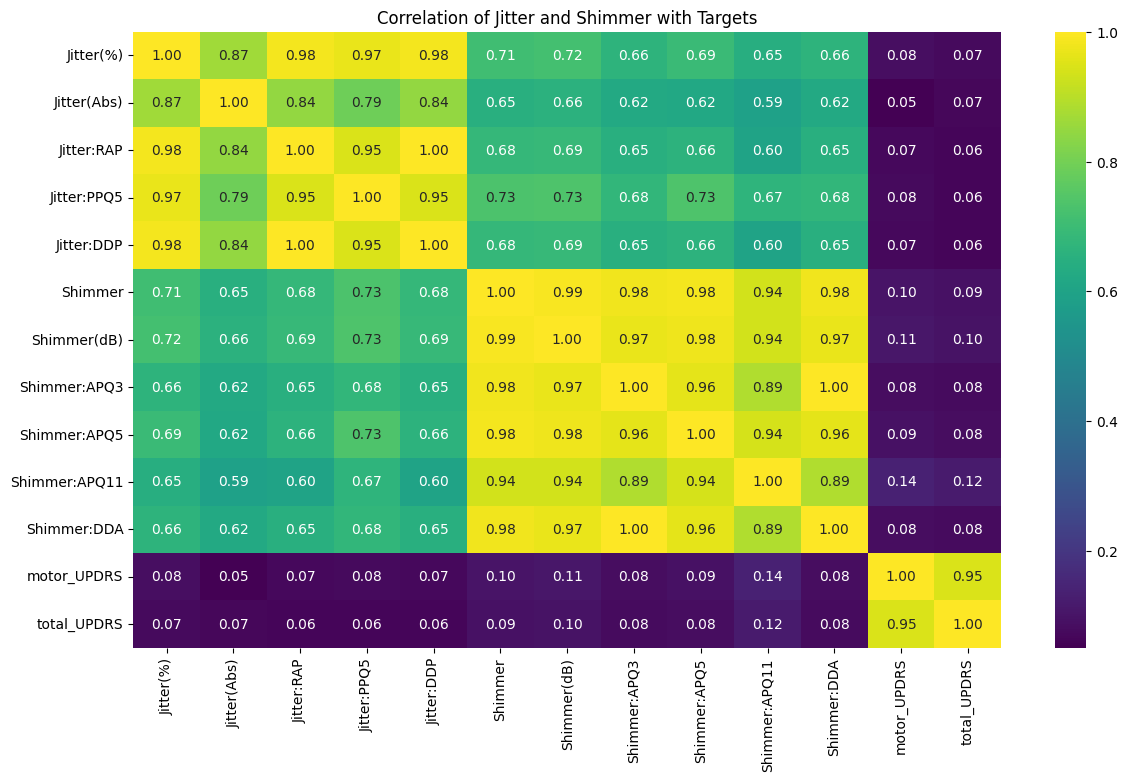

In [ ]:
# Relationship between Jitter, Shimmer, and UPDRS scores
jitter_features = ["Jitter(%)", "Jitter(Abs)", "Jitter:RAP", "Jitter:PPQ5", "Jitter:DDP"]
shimmer_features = ["Shimmer", "Shimmer(dB)", "Shimmer:APQ3", "Shimmer:APQ5", "Shimmer:APQ11", "Shimmer:DDA"]

plt.figure(figsize=(14, 8))
sns.heatmap(data[jitter_features + shimmer_features + ['motor_UPDRS', 'total_UPDRS']].corr(), annot=True, fmt=".2f", cmap="viridis")
plt.title("Correlation of Jitter and Shimmer with Targets")
plt.show()

Data Preprocessing

In [ ]:
# Encoding binary 'sex' feature if needed
data['sex'] = data['sex'].astype(int)

# Handling outliers (optional): Replace extreme outliers with 95th percentile values
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    q_low = data[col].quantile(0.01)
    q_high = data[col].quantile(0.99)
    data[col] = np.clip(data[col], q_low, q_high)

# Splitting features and target variables
X = data.drop(['motor_UPDRS', 'total_UPDRS'], axis=1)
y_motor = data['motor_UPDRS']
y_total = data['total_UPDRS']

# Train-test split
X_train, X_test, y_motor_train, y_motor_test = train_test_split(X, y_motor, test_size=0.2, random_state=42)
_, _, y_total_train, y_total_test = train_test_split(X, y_total, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Preparing the Data for Machine Learning Algorithms

In [ ]:
# Models and hyperparameter tuning
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

# Hyperparameter tuning for Random Forest and SVR
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVR': {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1]}
}

results = {}
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name in param_grids:
        grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_motor_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_motor_train)

    # Predictions and evaluation
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_motor_test, y_pred))
    mae = mean_absolute_error(y_motor_test, y_pred)
    r2 = r2_score(y_motor_test, y_pred)
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} -> RMSE: {rmse}, MAE: {mae}, R2: {r2}")

Training Linear Regression...
Linear Regression -> RMSE: 7.167047494043274, MAE: 6.0539797550237875, R2: 0.19335895458709462
Training Random Forest...
Random Forest -> RMSE: 0.38415850542936514, MAE: 0.17445585319148957, R2: 0.9976824951144565
Training SVR...
SVR -> RMSE: 4.095952593914289, MAE: 2.9269085128871186, R2: 0.7365430891519404


Training Linear Regression...
Linear Regression -> Train RMSE: 7.1021773315575185, Test RMSE: 7.167047494043274
Training Random Forest...
Random Forest -> Train RMSE: 0.15258832330431765, Test RMSE: 0.38415850542936514
Training SVR...
SVR -> Train RMSE: 3.815190897517409, Test RMSE: 4.095952593914289


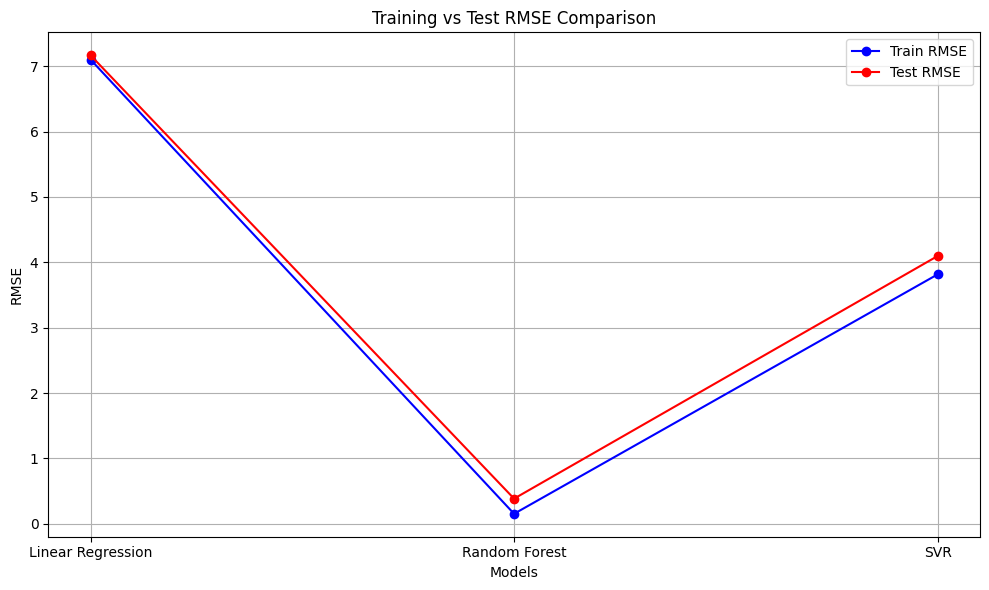

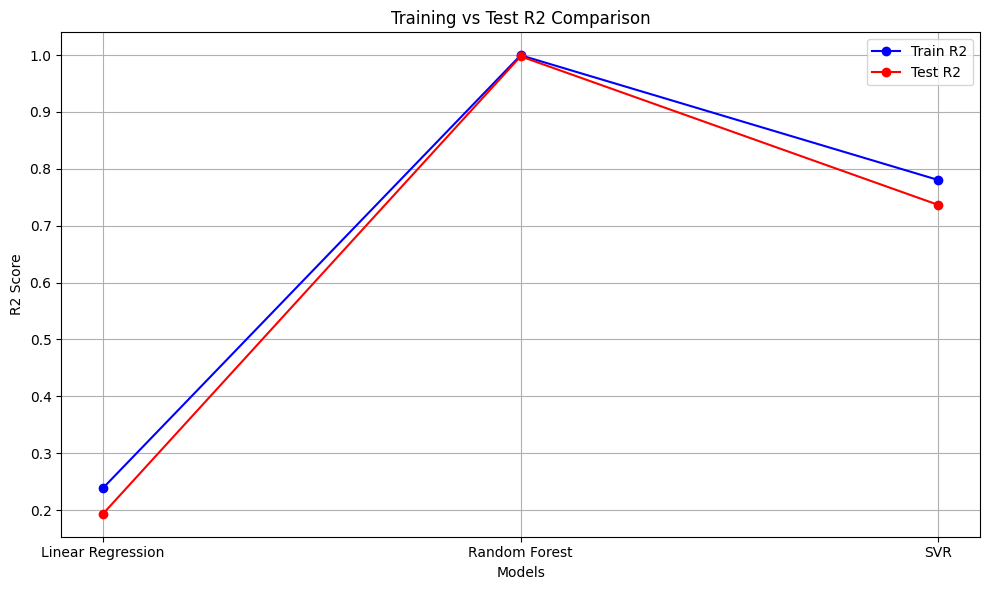

In [ ]:
# Models and hyperparameter tuning
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

# Hyperparameter tuning parameters for Random Forest and SVR
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVR': {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1]}
}

# Dictionaries to store training and testing results
training_results = {}
testing_results = {}

# Loop through each model
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Apply hyperparameter tuning if the model has a parameter grid
    if model_name in param_grids:
        grid_search = GridSearchCV(model, param_grids[model_name], cv=3, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_motor_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train, y_motor_train)

    # Predictions on training and testing data
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Evaluate on training set
    train_rmse = np.sqrt(mean_squared_error(y_motor_train, y_train_pred))
    train_r2 = r2_score(y_motor_train, y_train_pred)
    training_results[model_name] = {'RMSE': train_rmse, 'R2': train_r2}

    # Evaluate on test set
    test_rmse = np.sqrt(mean_squared_error(y_motor_test, y_test_pred))
    test_r2 = r2_score(y_motor_test, y_test_pred)
    testing_results[model_name] = {'RMSE': test_rmse, 'R2': test_r2}

    print(f"{model_name} -> Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

# Plot Training vs Test RMSE
train_rmse = [training_results[model]['RMSE'] for model in training_results]
test_rmse = [testing_results[model]['RMSE'] for model in testing_results]
models_list = list(training_results.keys())

plt.figure(figsize=(10, 6))
plt.plot(models_list, train_rmse, label='Train RMSE', marker='o', color='blue')
plt.plot(models_list, test_rmse, label='Test RMSE', marker='o', color='red')
plt.title("Training vs Test RMSE Comparison")
plt.xlabel("Models")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Training vs Test R2
train_r2 = [training_results[model]['R2'] for model in training_results]
test_r2 = [testing_results[model]['R2'] for model in testing_results]

plt.figure(figsize=(10, 6))
plt.plot(models_list, train_r2, label='Train R2', marker='o', color='blue')
plt.plot(models_list, test_r2, label='Test R2', marker='o', color='red')
plt.title("Training vs Test R2 Comparison")
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Plotting Model Evaluation

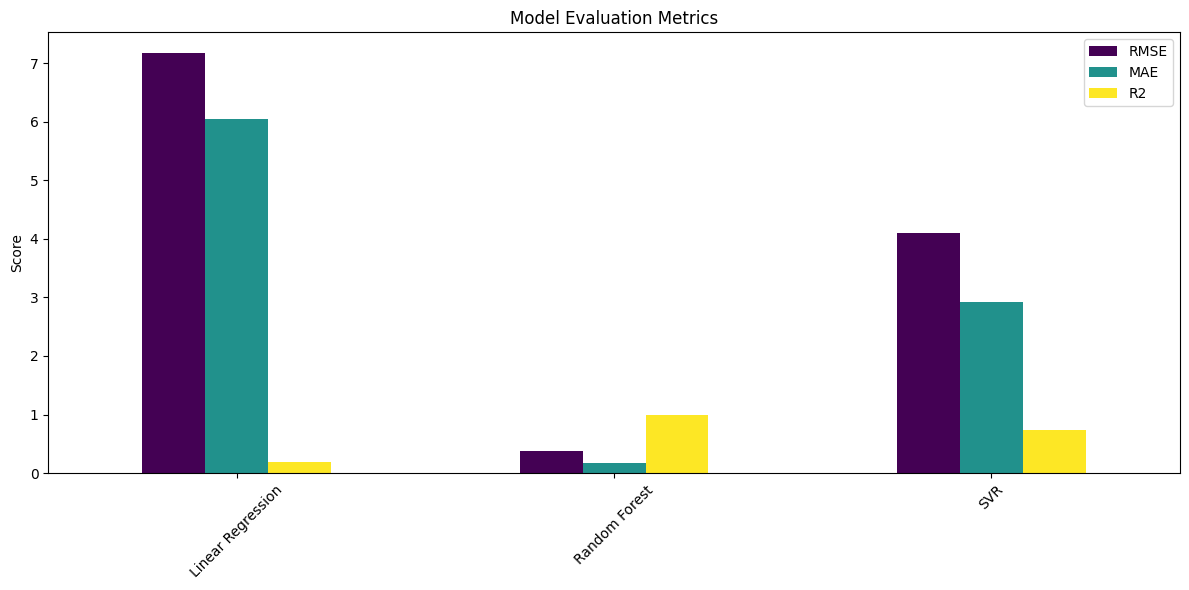

In [ ]:
metrics = ['RMSE', 'MAE', 'R2']
evaluation_df = pd.DataFrame(results).T[metrics]

evaluation_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Model Evaluation Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Adding cross validation to check how it will improve the model

Training Linear Regression with k-fold cross-validation...
Linear Regression Mean RMSE (Cross-Validation): 7.1276
Linear Regression Test Performance -> RMSE: 7.1670, MAE: 6.0540, R2: 0.1934
Training Random Forest with k-fold cross-validation...
Random Forest Test Performance -> RMSE: 0.3842, MAE: 0.1745, R2: 0.9977
Training SVR with k-fold cross-validation...
SVR Test Performance -> RMSE: 4.0960, MAE: 2.9269, R2: 0.7365


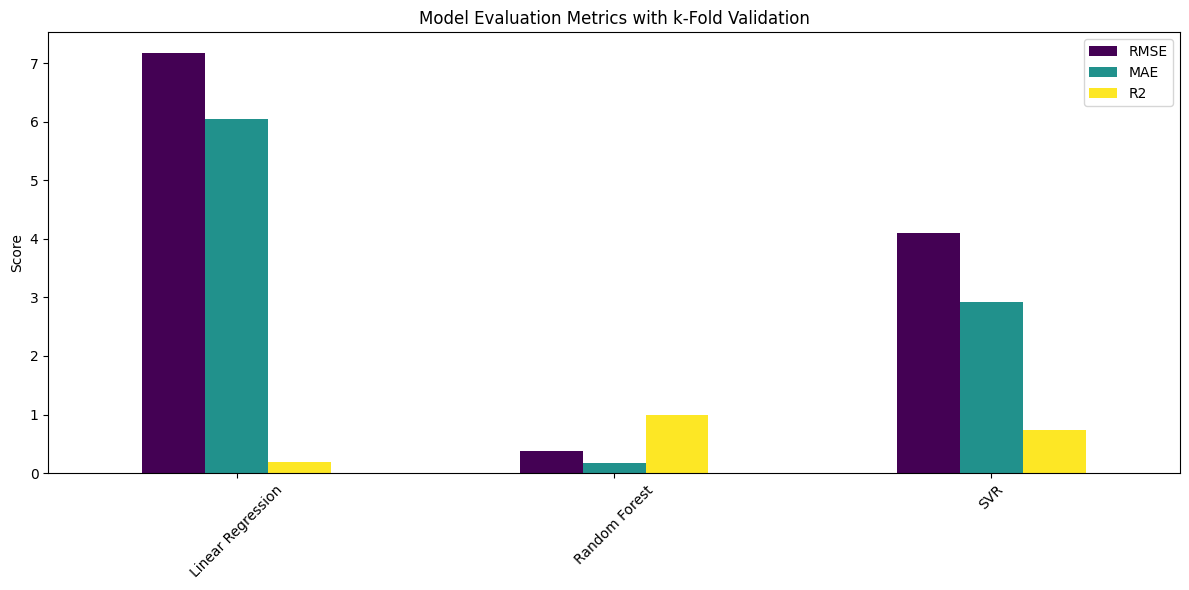

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Models and hyperparameter tuning
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR()
}

# Hyperparameter tuning for Random Forest and SVR
param_grids = {
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    'SVR': {'C': [0.1, 1, 10], 'epsilon': [0.01, 0.1]}
}

results = {}

# Train models with k-fold cross-validation
for model_name, model in models.items():
    print(f"Training {model_name} with k-fold cross-validation...")

    if model_name in param_grids:
        # Perform GridSearchCV with k-fold cross-validation
        grid_search = GridSearchCV(model, param_grids[model_name], cv=kf, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_motor_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        # Perform k-fold cross-validation manually for models without hyperparameter tuning
        scores = cross_val_score(best_model, X_train, y_motor_train, cv=kf, scoring='neg_mean_squared_error')
        mean_rmse = np.sqrt(-scores.mean())
        print(f"{model_name} Mean RMSE (Cross-Validation): {mean_rmse:.4f}")
        best_model.fit(X_train, y_motor_train)

    # Predictions on the test set
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_motor_test, y_pred))
    mae = mean_absolute_error(y_motor_test, y_pred)
    r2 = r2_score(y_motor_test, y_pred)

    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} Test Performance -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# Create a bar plot for the metrics
metrics = ['RMSE', 'MAE', 'R2']
evaluation_df = pd.DataFrame(results).T[metrics]

evaluation_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
plt.title("Model Evaluation Metrics with k-Fold Validation")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()
